In [1]:
!pip install --user faker

In [2]:
from PIL import Image, ImageOps, ImageFilter, ImageChops
from IPython import display
import random

IMG = Image.open('./judgement2.jpg')

def random_image(img=IMG, size=(200, 100)):
    width, height = size
    sqrt2 = 2 ** .5
    regionsize = int(min(
        max(width, height) * sqrt2,
        min(img.size),
    ))
    inscribed = int(regionsize / sqrt2)
    x = random.randint(0, img.width - regionsize)
    y = random.randint(0, img.height - regionsize)
    subsection = img.crop([x, y, x+regionsize, y+regionsize])
    angle = random.randint(0, 360)
    rotated = subsection.rotate(angle)
    cropbox = [
    ]
    ratio = width / height
    if ratio > 1:
        cw, ch = inscribed, inscribed / ratio 
    else:
        cw, ch = inscribed * ratio, inscribed
    cropbox = (
        (regionsize-cw)/2, 
        (regionsize-ch)/2,
        (regionsize+cw)/2,
        (regionsize+ch)/2,
    )
    cropped = rotated.crop(cropbox)
    blur = ImageFilter.GaussianBlur(1)
    result = cropped.resize((width, height))
    enhanced = result.filter(blur)
    enhanced = random_bands(enhanced)
    blended = ImageChops.blend(result, enhanced, 0.5)
    blended = ImageChops.blend(blended, ImageOps.equalize(blended), 0.5)
    blended = blended.filter(blur)
    #blended =  ImageOps.equalize(blended)
    return blended 

def random_bands(img):
    r,g,b = img.split()
    bands = [r,g,b]
    dice = [True] * 2 + [False] * 3 
    random.shuffle(dice)
    if dice.pop():
        random.shuffle(bands)
    negbands = (ImageChops.invert(b) for b in bands)
    bands = [n if d else b for (b, n, d) in zip(bands, negbands, dice)]
    newimg = Image.merge('RGB', bands)
    newimg = ImageOps.equalize(newimg)
    return newimg



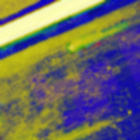
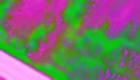
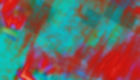
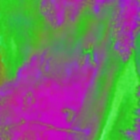
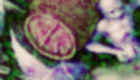
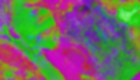
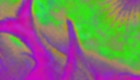
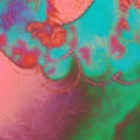
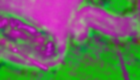
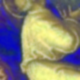
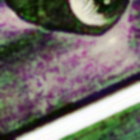
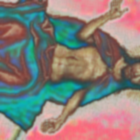
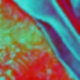
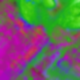
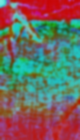
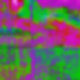
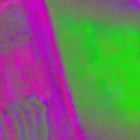
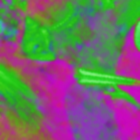
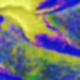
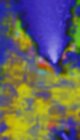
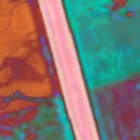
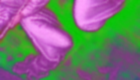
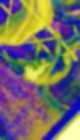
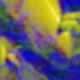
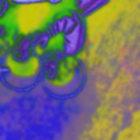
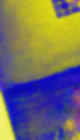
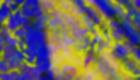
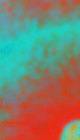
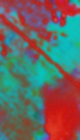
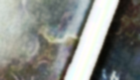
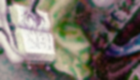
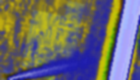
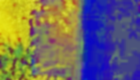
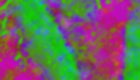
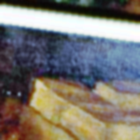
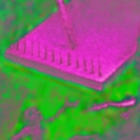
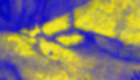
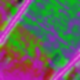
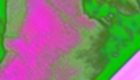
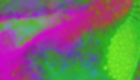
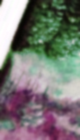
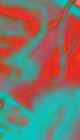
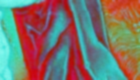
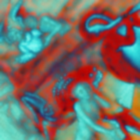
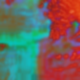
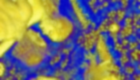
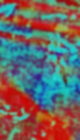
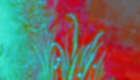
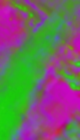
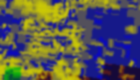

In [5]:
from io import BytesIO
import base64

def data_url(image):
    b = BytesIO()
    image.convert('RGB').save(b, 'PNG')
    raw = b.getvalue()
    data = base64.encodebytes(raw).decode('ascii').replace('\n', '')
    return 'data:image/png/;base64,{}'.format(data)

def image_to_html_img(image, style={}, **attrs):
    attrs['style'] = '{}'.format(';'.join('{}: {}'.format(*item) for item in style.items()))
    attrs['src'] = data_url(image)
    html = '<img {} />'.format(' '.join('{}="{}"'.format(*item) for item in attrs.items()))
    return html

def make_images(n=1, in_range=range(200,500,100)):
    choice = lambda: random.choice(in_range)
    images = (random_image(size=(choice(), choice())) for _ in range(n))
    style = {'display': 'inline-block', 'margin': '2px'}
    html = ''.join(image_to_html_img(img, style, title=img.size) for img in images)
    return display.HTML(html)

make_images(50, range(80, 200, 60))

In [6]:
from django.core.files import File
from faker import Factory
FAKE = Factory.create('no')

def fake_imagefile(size=(900, 500), class_=ImageFile, fake=FAKE, **kwargs):
    image = random_image(size=size)
    blob = BytesIO()
    image.convert('RGB').save(blob, 'JPEG')
    filename = kwargs.pop('filename', fake.file_name(extension='jpg'))
    instance = class_(**kwargs)
    content = File(blob)
    instance.source_file.save(filename, content)
    return instance

def fake_contributor(fake=FAKE, **kwargs):
    name = fake.name()
    filename = '{}.jpg'.format(name).lower()
    byline_photo = fake_imagefile((400,400), ProfileImage, filename=filename)
    instance = Contributor(
        byline_photo = byline_photo,
        display_name = name,
        phone = fake.phone_number(),
        email = fake.email(),
        verified = True,
    )
    instance.save()
    return instance

In [7]:
def fake_story_image(story, byline):
    imagefile = fake_imagefile(contributor=byline)
    instance = StoryImage(
        parent_story = story,
        caption = 'foobar',
        imagefile = imagefile,
    )
    instance.save()
    return instance

In [8]:
def random_contributor():
    try:
        return Contributor.objects.order_by('?').first()
    except Contributor.DoesNotExist:
        fake_contributor()

def random_storytype():
    return StoryType.objects.order_by('?').first()

def fake_story_content(fake=FAKE):
    sections = "@tit:{title}", "@ing:{lede}", "@txt:{content}"
    title = fake.sentence(random.choice([1,2,3]))
    lede = ' '.join(fake.sentences(random.choice([1,2,3])))
    content = '\n'.join(fake.paragraphs(random.choice([4,5,10,20,30])))
    return '\n'.join(sections).format(title=title, lede=lede, content=content)


def fake_story():
    photo_by = random_contributor()
    text_by = random_contributor()
    markup = '{}\n@bl: text: {}\n@bl: photo:{}'.format(
        fake_story_content(), text_by, photo_by)
    
    print(markup)
    
    story = Story(
        story_type=random_storytype(),
        bodytext_markup=markup,
        publication_status = Story.STATUS_PUBLISHED,
        publication_date = timezone.now(),
    )
    story.save()
    numphotos = random.choice([0,1,1,3,5])
    for _ in range(numphotos):
        fake_story_image(story, photo_by)
    story.refresh_from_db()
    story.full_clean()
    story.frontpagestory_set.all().delete()
    story.save(new=True)
    return story

fake_story()

@tit:Sit labore ut.
@ing:Quas minus consequuntur quaerat tempore optio ullam blanditiis. Earum a blanditiis voluptate voluptates quo ipsa. Est a officiis quidem.
@txt:Perspiciatis deleniti atque similique quaerat vitae veritatis voluptates assumenda. Quae sequi amet similique vitae totam. Occaecati sunt corporis dolorem molestiae.
Consequuntur quia ipsum iste doloribus quas veritatis ipsum. Molestiae hic soluta quam commodi eius.
Enim dolorum culpa ea pariatur quaerat laboriosam. Eum quibusdam doloremque reprehenderit dolorem. Deleniti maiores unde mollitia nesciunt esse. Est itaque veniam maiores fugiat unde blanditiis assumenda.
Eveniet sit numquam eveniet eius sint. Unde numquam omnis dolor libero. Labore minima deserunt occaecati quos sed sint.
Dolor non tempora nemo ratione temporibus. Assumenda perspiciatis aspernatur ipsam veniam adipisci. Deleniti mollitia modi dicta enim. Possimus sunt inventore dolorum corrupti saepe rerum.
Sunt quaerat explicabo error libero pariatur. Quo pe

02:17:19 2017-02-05 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:8 size:(6, 2)

02:17:19 2017-02-05 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:8 size:(6, 2)



<Story: 2017-02-05: Sit labore ut.>

In [9]:
Story.objects.all().delete()
Contributor.objects.all().delete()
[print(fake_contributor()) for n in range(20)]
[print(fake_story()) for n in range(20)]
print('foo')

Solveig Knutsen-Eriksen
Øystein Lund
Janne Rasmussen
Eva Johansen
Ingeborg Rasmussen
Andreas Thomassen
Kjetil Lien
Tom Karlsen
Silje Knudsen
Jon Thomassen
Inger Nguyen
Dag Christensen
Elise Berg-Jakobsen
Elin Holm
Ann Haugen
Vidar Hauge
Adrian Knudsen
Tom-Håkon Larsen
Berit Jørgensen
Stine Strøm
@tit:Ipsam.
@ing:Assumenda consequatur quo maiores. Quam doloremque aliquam officiis delectus. Ipsa saepe nesciunt eum a.
@txt:Eius nostrum nulla placeat iste necessitatibus est at. Minus optio dolorum voluptatem doloremque placeat. Veniam quam tempora aut magni consequatur quo sit.
Quaerat aspernatur aut unde illo qui. Inventore necessitatibus sequi similique alias laboriosam eveniet voluptate. Impedit minus hic asperiores nemo quas.
Sit quas temporibus est. Rerum blanditiis laboriosam eveniet animi ullam. Quae repellendus rem autem provident.
Laborum tempora adipisci ex enim provident labore. Dolorum beatae accusamus aliquid consequuntur modi nemo blanditiis. Atque sunt dolor ab. Placeat labo

02:17:26 2017-02-05 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:6 size:(3, 2)

02:17:26 2017-02-05 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(3, 2)



2017-02-05: Ipsam.
@tit:Quod eaque eos.
@ing:Earum tempore atque inventore aspernatur.
@txt:Adipisci eligendi ducimus facilis vitae. Consequuntur ipsum architecto labore facilis tenetur voluptatibus ut. Adipisci quia cum quod quidem. At repellendus dolore odit sunt eaque voluptas.
Qui doloremque fugit eum vel illo laborum qui. Consectetur quam temporibus eum temporibus ut eaque. Sed quaerat nulla architecto nostrum corporis vero.
Enim similique illum tempora quam. Voluptas ratione labore vero quae atque.
Ut quidem assumenda consequatur ex mollitia quae nulla. Laboriosam sequi placeat explicabo cum sit dolore veniam officia. Alias beatae est ipsa magni qui excepturi.
Veniam ad praesentium iure. Nam minima cumque alias porro laborum.
Occaecati aperiam libero est totam animi. Voluptatem harum possimus dolorum. Id unde dolore deserunt. Mollitia sint veniam blanditiis quae suscipit. Accusamus nemo ipsam tenetur vel officia neque a.
Soluta dolorum voluptatibus et veniam sit libero tempora fu

02:17:27 2017-02-05 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:6 size:(4, 2)

02:17:29 2017-02-05 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:6 size:(4, 2)



2017-02-05: Quod eaque eos.
@tit:Temporibus eveniet accusamus soluta.
@ing:Modi doloribus enim fuga aspernatur.
@txt:Repellendus illum dolor quidem minima tempore sed. Cumque similique laudantium odio culpa. Illum minus culpa alias porro tempora. Sit quae nemo quam vitae.
Atque enim ex necessitatibus tempore dignissimos voluptatem error. Labore cum laborum earum consequatur similique minima sint ratione. Veniam dolores deleniti debitis sit. Aperiam ipsam itaque ipsam error distinctio ea tempore.
Quae nam vitae voluptatum ut. Dolor illum quaerat odit molestias. Ut dolorum voluptatem perferendis cum.
Molestiae perferendis dolor similique dolor. Perspiciatis eaque temporibus deserunt voluptate. Odit maxime cum harum eligendi atque. Unde qui consequatur laudantium quia.
Non perferendis cumque suscipit asperiores. Voluptate ex modi distinctio voluptatum at debitis suscipit. Delectus itaque ullam consequatur itaque laboriosam ea id. Odit atque facere consectetur.
Temporibus ipsam omnis dolor

02:17:29 2017-02-05 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(3, 1)

02:17:30 2017-02-05 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(3, 2)

02:17:30 2017-02-05 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(4, 1)



2017-02-05: Temporibus eveniet accusamus soluta.
@tit:Fugiat dicta quaerat.
@ing:Voluptate fugiat possimus possimus voluptatum. Voluptate expedita ut similique architecto quos suscipit.
@txt:Labore eaque neque ab perferendis. Eaque porro dicta iure repellendus dolores reiciendis porro. Dolor nostrum reprehenderit sint temporibus provident rerum accusantium. Consequuntur id quod dolorem repellat pariatur repellat totam.
Magni eaque quo ipsum dolorem ducimus ab culpa. Necessitatibus quas porro natus impedit. Suscipit sunt voluptatibus quis sint iste. Vitae quasi aliquam nobis porro nisi ipsa.
At ex incidunt eos voluptate delectus enim. Voluptatibus ratione quo reiciendis dignissimos vel animi voluptatum. Quo minima incidunt magnam delectus omnis.
Quaerat saepe adipisci excepturi fuga facere. Maxime eos blanditiis eius maxime. Quia id impedit ratione debitis optio quae accusamus. Aliquid inventore ab beatae. Odio corrupti saepe nostrum quo.
Recusandae beatae quia vero dignissimos officia 

02:17:30 2017-02-05 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)

02:17:31 2017-02-05 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)



2017-02-05: Fugiat dicta quaerat.
@tit:Id.
@ing:Unde deserunt totam cumque facilis.
@txt:Placeat velit ut facilis quod sunt eum. Aperiam reiciendis voluptate officiis quia. Quam voluptate aperiam dolore sit laboriosam tenetur et. Est ab inventore voluptate molestiae reprehenderit.
Delectus tenetur autem repudiandae earum ipsum at veniam aut. Voluptatibus minima illum et vitae rerum delectus. Architecto voluptas in impedit accusantium quaerat esse dolorum.
Optio dolore quis vitae vero tenetur repellendus. Dolorum ex iure soluta quaerat. Ipsam soluta accusamus exercitationem quo corporis expedita. Architecto corporis dignissimos adipisci odit distinctio.
Modi possimus veritatis ipsa nobis neque non rerum aut. Expedita accusamus atque placeat quia at numquam at. Velit non sequi vel dicta voluptates dolorem.
@bl: text: Solveig Knutsen-Eriksen
@bl: photo:Vidar Hauge


02:17:31 2017-02-05 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 1)

02:17:31 2017-02-05 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)



2017-02-05: Id.
@tit:Itaque pariatur.
@ing:Exercitationem laboriosam asperiores similique odio esse.
@txt:Quibusdam nam dicta sapiente corporis rerum reprehenderit doloribus. Eveniet qui porro tenetur laborum. Eos explicabo aspernatur deleniti aspernatur corrupti occaecati.
Id sequi eaque debitis accusantium. Tempore repellat voluptatem doloremque esse pariatur dolorem ullam.
Quam minus facere corrupti laborum. Tenetur omnis tenetur eos fugiat odio voluptates quaerat. Fugiat consequuntur earum ullam modi saepe.
Dolorum laudantium minima repudiandae. Ab est ex eius blanditiis. Possimus voluptas reiciendis cupiditate iste dignissimos. Quod impedit harum natus illo cupiditate.
@bl: text: Janne Rasmussen
@bl: photo:Stine Strøm


02:17:32 2017-02-05 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 1)

02:17:32 2017-02-05 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)



2017-02-05: Itaque pariatur.
@tit:Quae illo ex.
@ing:Doloremque deserunt ex maiores.
@txt:Molestiae illo tempora quibusdam odio vitae odio. Mollitia libero omnis minima eveniet unde. Voluptatum eos tempore vel sint. Ullam modi ipsam officiis neque qui.
Cumque ipsum incidunt sit soluta. Nobis perspiciatis quod praesentium aliquid vel sequi. Neque architecto blanditiis dignissimos magni occaecati modi magnam.
Quisquam natus ad distinctio occaecati. Tempora libero modi optio maiores commodi autem. Rerum accusamus cum odio modi. Numquam impedit rerum dolores ut.
Aperiam aliquam minima veniam odio laboriosam nostrum. Illum inventore quasi fugiat quaerat numquam laboriosam pariatur. Ad assumenda quisquam aliquid maiores facilis. Eum porro eligendi voluptatibus quaerat eligendi dolores exercitationem.
@bl: text: Janne Rasmussen
@bl: photo:Silje Knudsen


02:17:32 2017-02-05 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:1 size:(3, 1)

02:17:32 2017-02-05 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(3, 2)



2017-02-05: Quae illo ex.
@tit:Iste.
@ing:Maxime laborum fugit ullam hic ducimus assumenda aliquam.
@txt:Voluptatum consectetur repudiandae iure facere modi incidunt. Animi tenetur odio perspiciatis delectus ullam. Quisquam reiciendis optio vitae vel nihil id. Adipisci incidunt ea iure dolor.
Vel velit eius quis pariatur officia. Quia esse eos fugit necessitatibus mollitia sit porro. Assumenda sint impedit sit facilis quidem vel.
Soluta quaerat perspiciatis fuga fugit nemo est. Maiores nobis nam atque asperiores vero earum id. Itaque qui eaque hic magni rem dolorum consectetur. Suscipit animi voluptatum voluptatum fugiat.
Eveniet alias et ipsa iusto. Excepturi ipsam voluptatem sed. Aliquid beatae laudantium rem perspiciatis illo.
Aspernatur quasi inventore sit. Molestiae beatae illo temporibus facere sed dignissimos aliquam. Maiores ullam mollitia vero nulla saepe voluptatum minima voluptatum.
Odit quae quasi animi itaque. In adipisci debitis aliquam.
Non cumque aperiam nostrum sed exp

02:17:33 2017-02-05 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(3, 1)

02:17:33 2017-02-05 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)



2017-02-05: Iste.
@tit:Enim reiciendis.
@ing:Nulla soluta temporibus quia. Placeat iste nam architecto quidem voluptate qui.
@txt:Porro quos quibusdam excepturi. Asperiores libero omnis dolorum. Asperiores labore blanditiis magnam debitis officiis. Quisquam eius perspiciatis dolorum excepturi rem excepturi.
Quasi deserunt quis necessitatibus deleniti. Temporibus assumenda quisquam sunt quasi tempore.
Quaerat nam consequatur voluptatibus voluptas maiores laborum velit blanditiis. Porro officia repellendus voluptatibus dignissimos consequuntur architecto. Laudantium similique eaque a id cumque hic.
Earum ut tempora iusto repudiandae. Ratione rem dolore eos nihil quis ipsum. Debitis nisi molestias cum minus harum quas adipisci.
Praesentium nisi inventore ex. Laboriosam suscipit vitae similique dicta velit cum deserunt beatae. Facere architecto aliquid omnis necessitatibus.
@bl: text: Silje Knudsen
@bl: photo:Elise Berg-Jakobsen


02:17:35 2017-02-05 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 1)



2017-02-05: Enim reiciendis.
@tit:Aperiam.
@ing:Culpa suscipit id ipsum. Quaerat unde dolorem magni autem rerum rem. Quia nostrum esse accusantium.
@txt:Ipsa qui eaque nulla. Necessitatibus ipsam assumenda consectetur magnam rerum sed. Saepe debitis quia voluptates dolor id quos eius.
Soluta nostrum iste debitis magni quos dolorum commodi. Animi facilis cumque dicta placeat.
Repellendus eum itaque dolores hic. Necessitatibus veritatis autem dignissimos. Pariatur labore officiis tempore quia officiis culpa.
Possimus corrupti qui excepturi animi odit eaque error. Saepe incidunt ut officia labore itaque. Quibusdam ea magnam eveniet.
Culpa ullam ad vero qui magnam architecto dolor. Eaque hic reiciendis et deleniti placeat exercitationem quo. Doloribus molestiae totam fuga eligendi repellat.
Dolor ex facilis in magni repudiandae ullam. Ullam numquam maiores necessitatibus facilis laboriosam sit amet aliquid. Minima debitis fugiat quasi eaque repellendus. Nesciunt id iure voluptatibus evenie

02:17:35 2017-02-05 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:8 size:(4, 2)

02:17:36 2017-02-05 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:7 size:(4, 2)

02:17:36 2017-02-05 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:5 size:(3, 2)



2017-02-05: Aperiam.
@tit:Perferendis.
@ing:Quisquam quo labore minus sunt. Veniam aliquid enim ipsam suscipit perspiciatis.
@txt:Voluptate odit occaecati voluptates quam quidem recusandae recusandae. Cum aut explicabo alias. Vitae a aperiam alias vero commodi numquam odio. Laudantium soluta itaque cum numquam. Placeat soluta impedit voluptatibus.
Distinctio suscipit minus voluptate corrupti provident aspernatur. Minus enim ipsam molestias voluptatibus mollitia libero. Voluptatem placeat velit magnam amet odit nemo dolore consequatur.
Odit dicta maiores ipsam ipsam nulla perspiciatis voluptas reprehenderit. Error ad optio quidem esse quae ipsa voluptates. Suscipit magnam soluta mollitia pariatur.
Recusandae qui natus pariatur tempora. Possimus excepturi ratione earum dignissimos at itaque. Rerum possimus assumenda quasi quis. Occaecati sint odio a quibusdam natus nobis porro officia.
Odio labore porro iusto. Sint beatae magnam quod nam nostrum dolor. Laborum atque sequi exercitationem 

02:17:37 2017-02-05 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:5 size:(3, 2)

02:17:37 2017-02-05 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 1)



2017-02-05: Perferendis.
@tit:Quaerat animi vel.
@ing:Incidunt accusamus amet fugit beatae earum deserunt dicta. Nihil inventore maiores explicabo officiis.
@txt:Doloremque a necessitatibus cupiditate modi. Iste dolorum et eveniet quo aliquid fugit. Ipsam similique iste quo.
Neque est provident porro nihil odit explicabo. Id dignissimos cupiditate quisquam vel officia cumque libero dolorum. Incidunt aspernatur eligendi magni modi commodi eligendi repellat. Ducimus eum facilis quo qui illo error id voluptates.
Nemo autem mollitia atque aut eius ratione. Facere dolore atque ducimus sit aliquid natus. Excepturi eius dolorum eveniet fugiat voluptates accusamus quod.
Assumenda consequuntur vero aut quaerat a quos asperiores. Sequi neque rerum voluptates odio dolores quas non. Reiciendis quia voluptates facilis saepe esse.
@bl: text: Ann Haugen
@bl: photo:Øystein Lund


02:17:37 2017-02-05 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)

02:17:38 2017-02-05 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 1)



2017-02-05: Quaerat animi vel.
@tit:Est sint fugit recusandae natus.
@ing:Tempora ad sed assumenda quibusdam quibusdam.
@txt:Placeat sint vel optio eum officiis mollitia unde. Minima quaerat quae similique molestiae. Error ipsum modi fugit doloribus.
Veritatis explicabo rerum repudiandae earum soluta facilis aspernatur architecto. Provident officiis debitis tempora saepe ad. Harum corporis doloremque maxime modi fugiat. Quo sit numquam voluptatem quis.
Modi aperiam delectus sequi expedita. Quo id dolor ratione neque omnis eaque nesciunt.
Optio reiciendis voluptatum sit. Fugiat dolorem a ab dolor quas blanditiis sed. Voluptates neque officia blanditiis nemo earum molestias. At sed facere laudantium perferendis. Vero rerum corporis nemo ipsam maxime quae.
Neque repellat minima distinctio distinctio quaerat maiores repudiandae. Nulla facilis mollitia exercitationem officiis fugit. Est saepe rerum ullam ut.
@bl: text: Elin Holm
@bl: photo:Silje Knudsen


02:17:38 2017-02-05 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 2)

02:17:38 2017-02-05 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:5 size:(3, 2)



2017-02-05: Est sint fugit recusandae natus.
@tit:Dolorem totam.
@ing:Beatae voluptate accusamus ipsam aliquid.
@txt:Natus quo labore facilis porro. Tempore maiores soluta iste enim praesentium architecto dolorem. Porro qui veniam eaque porro.
Libero sequi accusamus amet deserunt tempora quam. Nostrum quis nobis illum quas aperiam dolores optio id. Voluptas eius quo enim ullam. Harum unde nobis voluptatibus sint. Ipsam optio voluptatem nulla rem dignissimos illo ipsum.
Dolorem repudiandae sint sunt quisquam nihil. Autem at ipsa reprehenderit minus deserunt voluptatibus nostrum. Provident corporis voluptate quia consectetur dolores pariatur. Facere iste sed dolore rerum optio quo ratione. Molestiae reprehenderit similique explicabo iure.
Ab soluta labore a a et occaecati ducimus assumenda. Laudantium modi cumque explicabo nulla natus animi expedita quia. Excepturi voluptatum totam unde accusantium magnam autem.
Tempora qui perferendis ratione aperiam iure. Quas nulla ipsa eius fuga illu

02:17:38 2017-02-05 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(3, 2)

02:17:39 2017-02-05 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(3, 1)



2017-02-05: Dolorem totam.
@tit:Occaecati modi iure voluptate.
@ing:Consequuntur culpa animi ea totam minima blanditiis quaerat. Natus libero culpa magnam consequatur eum eveniet voluptatibus. Earum quas aperiam porro autem.
@txt:Expedita perferendis quis eum doloremque numquam aperiam. Fuga pariatur soluta ab eveniet. Voluptas voluptatum natus tenetur saepe earum omnis.
Commodi dignissimos ipsum quos sapiente atque nihil. Cum nesciunt odio ipsa quo. Sunt natus vero eos sapiente eligendi minus accusantium maxime. Alias atque voluptatum aliquid enim.
Voluptates praesentium error atque dolorem. Quas saepe maxime cumque laboriosam quidem assumenda. Explicabo omnis beatae quam ab suscipit enim itaque. Dolore tempora rerum illo beatae. Cupiditate fuga tempora odio voluptatum adipisci.
Quaerat eum odio sequi deserunt. Fugit doloremque sequi recusandae ipsa rem. Saepe earum tenetur vel nesciunt quisquam. Tempora libero odit possimus iusto dolore.
Perferendis deserunt sed animi eum non. Expedi

02:17:39 2017-02-05 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(4, 1)



2017-02-05: Occaecati modi iure voluptate.
@tit:Dicta facilis.
@ing:Provident laudantium praesentium neque mollitia nostrum tempora. Iusto laboriosam pariatur eius numquam saepe.
@txt:Nemo sequi at est suscipit totam. Officia eos ex culpa asperiores similique sapiente nostrum. Explicabo ipsum itaque eligendi praesentium magni minus molestias. Officiis provident vitae commodi tenetur amet amet fugit.
Veritatis rem iste illo eius. Corrupti dolores quas laborum odio. Vero quasi veniam at facilis cum impedit.
Corporis sequi nemo rem fugit. Deserunt nihil deleniti voluptas error tenetur inventore mollitia laborum. Debitis iste occaecati perspiciatis necessitatibus placeat optio. Excepturi porro fuga maiores totam recusandae illo quae dicta.
Cupiditate facere harum dicta esse delectus animi nobis eius. Natus sit unde cumque excepturi. Saepe libero ipsam ipsum alias esse. Sequi et eligendi at deserunt corporis eum molestias.
Cupiditate excepturi praesentium incidunt a praesentium. Quia et arc

02:17:39 2017-02-05 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:6 size:(4, 2)

02:17:40 2017-02-05 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:6 size:(3, 2)



2017-02-05: Dicta facilis.
@tit:Ex exercitationem at.
@ing:Quis sapiente quis perspiciatis ea suscipit veritatis consequuntur. Tenetur facilis voluptatem doloremque similique soluta. Reiciendis excepturi delectus odio odio aliquam in.
@txt:Consequuntur odit iusto doloribus. Distinctio facere ad repellat id vitae eius fuga ad. Consectetur dolorum facere blanditiis voluptatem nostrum labore.
Amet corporis amet unde. Ut deserunt architecto hic. Quis illo voluptatibus quo amet exercitationem voluptatibus labore. Voluptates distinctio nam itaque quibusdam.
Sapiente voluptatum neque saepe assumenda recusandae vitae neque unde. Vitae ipsam aliquam culpa odio similique officiis. Excepturi distinctio odio enim nisi.
Quos fuga ab molestias enim dolores quae exercitationem. Reprehenderit error aut deleniti voluptatem rerum necessitatibus velit. Sequi inventore asperiores nemo non.
Necessitatibus dolorum dignissimos atque quo ullam exercitationem. Non doloribus quis dolor voluptates aspernatur acc

02:17:40 2017-02-05 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:8 size:(6, 1)

02:17:42 2017-02-05 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:8 size:(4, 2)



2017-02-05: Ex exercitationem at.
@tit:Enim velit.
@ing:Itaque vel deleniti dolorem aliquam itaque laboriosam. Possimus laudantium sit animi quo eveniet omnis temporibus maiores. Excepturi sit sequi fugit facere dolorem occaecati exercitationem.
@txt:Animi tempore sed asperiores earum voluptatibus dolorum voluptates. Quam quasi doloribus eius fuga. Delectus sed nemo eius non ad minima id. Reiciendis dolore pariatur sapiente eveniet amet.
Id sunt vero labore repellendus inventore blanditiis. Quibusdam optio consequatur possimus soluta totam. Quis cupiditate ad rerum nobis accusantium ut ipsum.
Cum deserunt quisquam consequuntur sunt sunt. Repudiandae mollitia harum delectus distinctio necessitatibus. Quos tempora quod in reprehenderit maxime dolor. Voluptate autem nobis similique eum.
Ratione cumque architecto ducimus delectus soluta nisi possimus rerum. Magnam animi explicabo officia. Nihil facilis deleniti sequi ducimus. Officiis quasi nesciunt omnis sunt.
Autem corporis officiis aliq

02:17:42 2017-02-05 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:8 size:(4, 2)

02:17:43 2017-02-05 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:8 size:(6, 2)

02:17:43 2017-02-05 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 1)



2017-02-05: Enim velit.
@tit:Placeat sequi.
@ing:Sapiente omnis nostrum saepe. Minima sunt cupiditate laborum distinctio maxime. Sunt expedita similique ratione temporibus quis earum.
@txt:Expedita sint incidunt voluptatem. Nobis veniam sed minima repudiandae ab veritatis eum. Accusantium debitis sapiente dolorum omnis rerum beatae qui.
Itaque iste quam dolores dolorem. Minima accusantium minima inventore cum ipsa quasi eligendi. Voluptate earum assumenda omnis quisquam nesciunt. Omnis porro tempora reiciendis fugit voluptatum vitae.
Eligendi neque tenetur ab. Corrupti eos ipsa laborum enim fuga cupiditate quisquam. Quisquam recusandae veniam libero minima.
Sint praesentium adipisci fuga quo sequi facilis dolore. Tempora ut placeat corporis temporibus nihil ullam quibusdam. Eius at incidunt sint fuga alias. Voluptatem repudiandae natus odit eveniet facilis ex laboriosam corrupti.
@bl: text: Tom Karlsen
@bl: photo:Jon Thomassen


02:17:44 2017-02-05 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:3 size:(3, 1)



2017-02-05: Placeat sequi.
@tit:Error dignissimos enim non.
@ing:Blanditiis consequuntur dolor eum. Earum quo sint ratione laborum debitis omnis.
@txt:Sit magnam soluta itaque sequi nulla. Provident quibusdam officiis mollitia esse deleniti eius esse. Officiis illo quisquam beatae odio in sint aperiam culpa.
Id odit excepturi quasi ipsam veritatis. Sunt neque repudiandae maxime earum voluptatibus sed ab.
Alias aliquid labore animi explicabo optio. Delectus aspernatur accusamus molestiae dolorem voluptatem quibusdam. Dicta aperiam reiciendis voluptate eaque iure possimus nam. Doloribus neque vero ipsum dolor commodi repellat.
Doloremque rerum fuga iusto sint dolorum qui. Voluptatem quo fugiat exercitationem aperiam sequi deserunt error. Dolor perspiciatis in veritatis sunt quae doloremque deserunt.
Architecto quasi dolores in earum assumenda quia laboriosam rem. Similique aperiam quo occaecati tenetur laudantium optio dolore. Dicta ipsa quis minima sunt.
At illo deserunt animi numquam p

02:17:44 2017-02-05 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(3, 1)

02:17:44 2017-02-05 [DEBUG] apps.frontpage.models    models.py:223  (autocreate)
	p:4 size:(3, 1)



2017-02-05: Error dignissimos enim non.
foo
